In [17]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, f1_score, confusion_matrix
import joblib

In [18]:
DATA_FOLDER = r"/home/check/DATA/university/yr3, hk1/DS102 - ML for Statistic/Đồ án/goodread/DS102/DATA/gold/v1/"
MODELS_FOLDER = r"/home/check/DATA/university/yr3, hk1/DS102 - ML for Statistic/Đồ án/goodread/DS102/models/LightGBM & Catboost/"
PLOTS_FOLDER = os.path.join(MODELS_FOLDER, "plots")
os.makedirs(PLOTS_FOLDER, exist_ok=True)

TEST_FILE = DATA_FOLDER+"test_1.csv"
target_cols = ['Commercial_success', 'Popular_success', 'Critical_success']

In [19]:
test_df = pd.read_csv(os.path.join(DATA_FOLDER, TEST_FILE))
X_test = test_df.drop(columns=target_cols)
y_test = test_df[target_cols]

In [20]:
model_files = {
    "logistic": "processed_logistic.joblib",
    "rf": "processed_rf.joblib",
    "svm": "processed_svm.joblib",
    "xgb": "processed_xgb.joblib",
    "lightgbm": "processed_lightgbm_separate.joblib",
    "catboost": "processed_catboost_separate.joblib"
}

In [30]:
models = {}
print("Đang load 6 model đã train...")
for name, file in model_files.items():
    path = os.path.join(MODELS_FOLDER, file)
    path1 = os.path.join('/home/check/DATA/university/yr3, hk1/DS102 - ML for Statistic/Đồ án/goodread/DS102/models/tradition', file)
    if os.path.exists(path):
        models[name] = joblib.load(path)
        print(f"   → Loaded {name.upper()}")
    else:
        models[name] = joblib.load(path1)
        print(f"   → Loaded {name.upper()}")


Đang load 6 model đã train...
   → Loaded LOGISTIC
   → Loaded RF
   → Loaded SVM
   → Loaded XGB
   → Loaded LIGHTGBM
   → Loaded CATBOOST


In [31]:
feature_importance = {}
results = {}  # Để lưu F1-macro cho bảng tổng kết

print("\n" + "="*80)
print("CLASSIFICATION REPORT ĐẦY ĐỦ - 6 MODEL (GOLD_1)")
print("="*80)

for name, model in models.items():
    print(f"\n{'-'*30} {name.upper()} {'-'*30}")
    
    # Predict đúng cách theo loại model
    if name in ["lightgbm", "catboost"]:
        # Model riêng nhãn
        y_pred = np.zeros((len(X_test), 3))
        for i, col in enumerate(target_cols):
            y_pred_shifted = model[col].predict(X_test)
            y_pred[:, i] = y_pred_shifted.flatten() + 1
    elif name == "xgb":
        y_pred = model.predict(X_test) + 1
    else:
        y_pred = model.predict(X_test)
    
    # Classification Report đầy đủ
    for i, col in enumerate(target_cols):
        print(f"\n{col.upper()}")
        print(classification_report(
            y_test.iloc[:, i],
            y_pred[:, i],
            target_names=[f'Class {c}' for c in range(1, 6)],
            digits=3
        ))
    
    # F1-macro scores
    f1_scores = {}
    for i, col in enumerate(target_cols):
        f1 = f1_score(y_test.iloc[:, i], y_pred[:, i], average='macro')
        f1_scores[col] = round(f1, 4)
    avg_f1 = np.mean(list(f1_scores.values()))
    f1_scores['avg'] = round(avg_f1, 4)
    results[name] = f1_scores
    
    print(f"\nF1-macro: {f1_scores} | Avg F1: {avg_f1:.4f}")


CLASSIFICATION REPORT ĐẦY ĐỦ - 6 MODEL (GOLD_1)

------------------------------ LOGISTIC ------------------------------

COMMERCIAL_SUCCESS
              precision    recall  f1-score   support

     Class 1      0.819     0.868     0.843        68
     Class 2      0.672     0.703     0.687        64
     Class 3      0.415     0.319     0.361        69
     Class 4      0.636     0.817     0.715       120
     Class 5      0.958     0.708     0.814        96

    accuracy                          0.700       417
   macro avg      0.700     0.683     0.684       417
weighted avg      0.709     0.700     0.696       417


POPULAR_SUCCESS
              precision    recall  f1-score   support

     Class 1      0.764     0.592     0.667        71
     Class 2      0.590     0.790     0.675       100
     Class 3      0.534     0.540     0.537        87
     Class 4      0.614     0.510     0.557       100
     Class 5      0.649     0.627     0.638        59

    accuracy               

In [32]:
print("\n" + "="*60)
print("TỔNG KẾT F1-MACRO & ACCURACY")
print("="*60)
print(f"{'Model':<12} {'Commercial':<12} {'Popular':<10} {'Critical':<10} {'Avg F1':<8} {'Accuracy'}")
print("-"*70)

for name, scores in results.items():
    # Tính accuracy trung bình 3 nhãn
    if name in ["lightgbm", "catboost"]:
        y_pred_all = np.zeros((len(X_test), 3))
        for i, col in enumerate(target_cols):
            y_pred_shifted = models[name][col].predict(X_test)
            y_pred_all[:, i] = y_pred_shifted.flatten() + 1
    elif name == "xgb":
        y_pred_all = models[name].predict(X_test) + 1
    else:
        y_pred_all = models[name].predict(X_test)
    
    acc = np.mean([(y_pred_all[:, i] == y_test.iloc[:, i]).mean() for i in range(3)])
    
    print(f"{name.upper():<12} {scores['Commercial_success']:<12.3f} {scores['Popular_success']:<10.3f} "
          f"{scores['Critical_success']:<10.3f} {scores['avg']:<8.3f} {acc:.3f}")


TỔNG KẾT F1-MACRO & ACCURACY
Model        Commercial   Popular    Critical   Avg F1   Accuracy
----------------------------------------------------------------------
LOGISTIC     0.684        0.615      0.681      0.660    0.672
RF           0.805        0.554      0.604      0.655    0.675
SVM          0.701        0.595      0.653      0.650    0.650
XGB          0.907        0.774      0.744      0.809    0.812
LIGHTGBM     0.927        0.789      0.799      0.838    0.837
CATBOOST     0.924        0.803      0.769      0.832    0.835


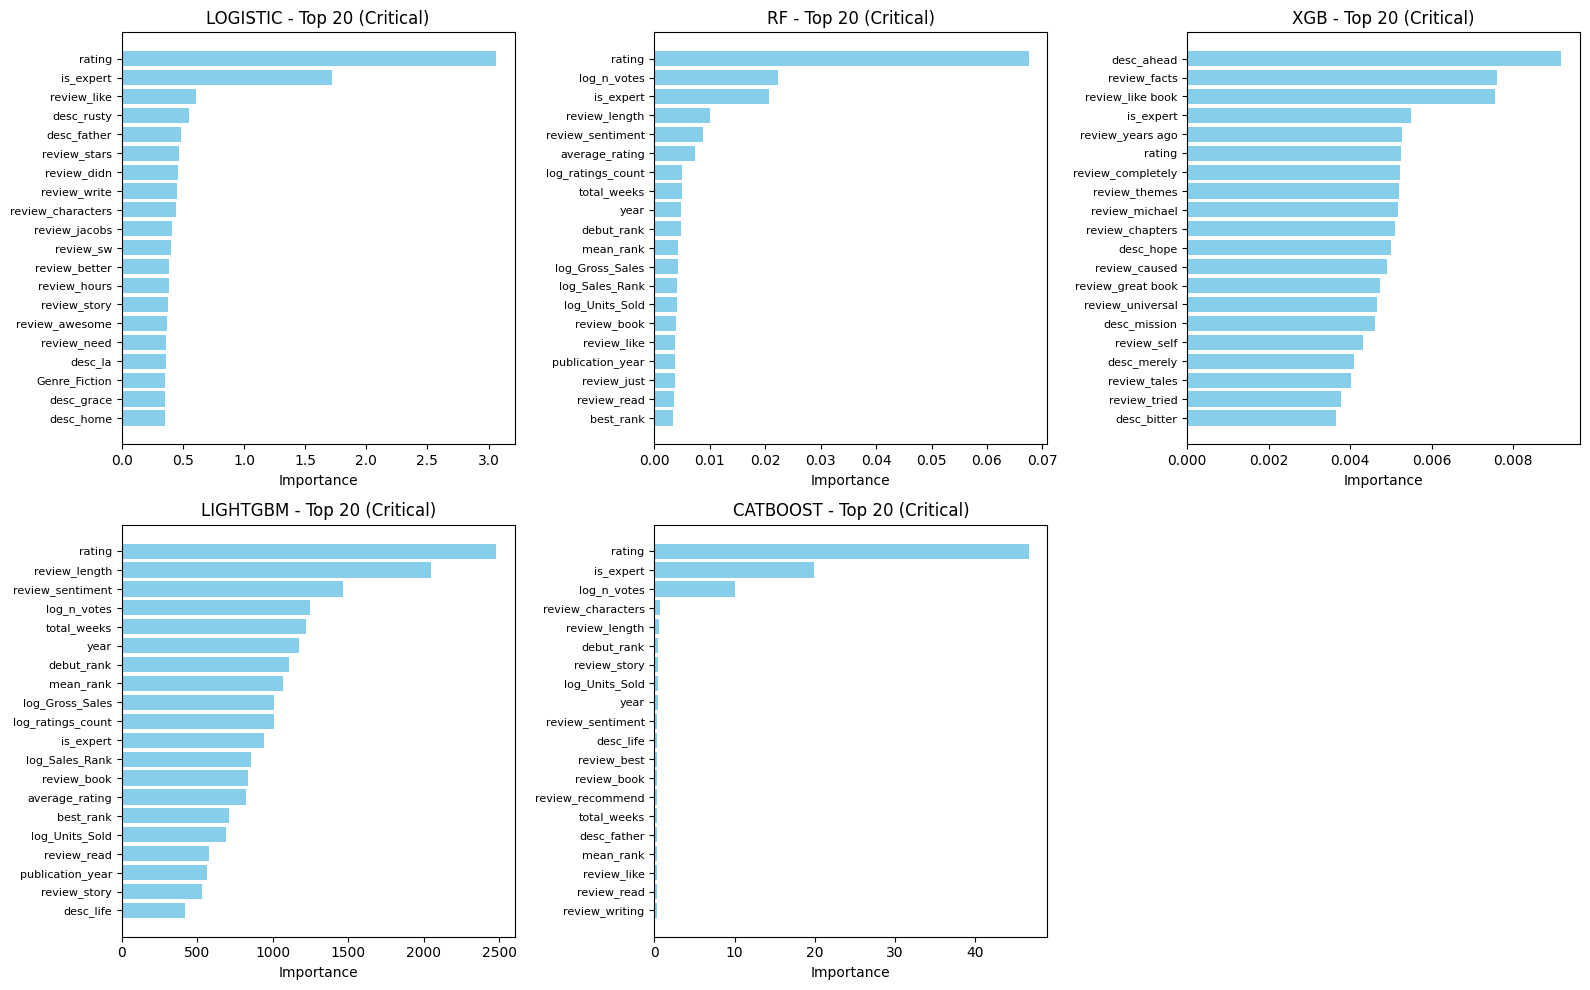

In [33]:
plt.figure(figsize=(16, 10))
loaded_count = 0
for name, model in models.items():
    if name in ['rf', 'xgb', 'lightgbm', 'catboost', 'logistic']:
        if name in ["lightgbm", "catboost"]:
            est = model['Critical_success']
            if name == "catboost":
                imp = est.get_feature_importance()
            else:
                imp = est.feature_importances_
        elif name == "logistic":
            est = model.estimators_[2]
            imp = np.abs(est.coef_).mean(axis=0)
        else:
            est = model.estimators_[2]
            imp = est.feature_importances_
        
        top20 = sorted(zip(X_test.columns, imp), key=lambda x: x[1], reverse=True)[:20]
        feature_importance[name] = top20
        
        plt.subplot(2, 3, loaded_count + 1)  # 2x3 vì có 6 model
        feats, scores = zip(*top20)
        y_pos = np.arange(len(feats))
        plt.barh(y_pos, scores, color='skyblue')
        plt.yticks(y_pos, feats, fontsize=8)
        plt.gca().invert_yaxis()
        plt.title(f'{name.upper()} - Top 20 (Critical)')
        plt.xlabel('Importance')
        loaded_count += 1

plt.tight_layout()
plt.savefig(os.path.join(PLOTS_FOLDER, 'final_feature_importance_advanced.png'), dpi=300, bbox_inches='tight')
plt.show()

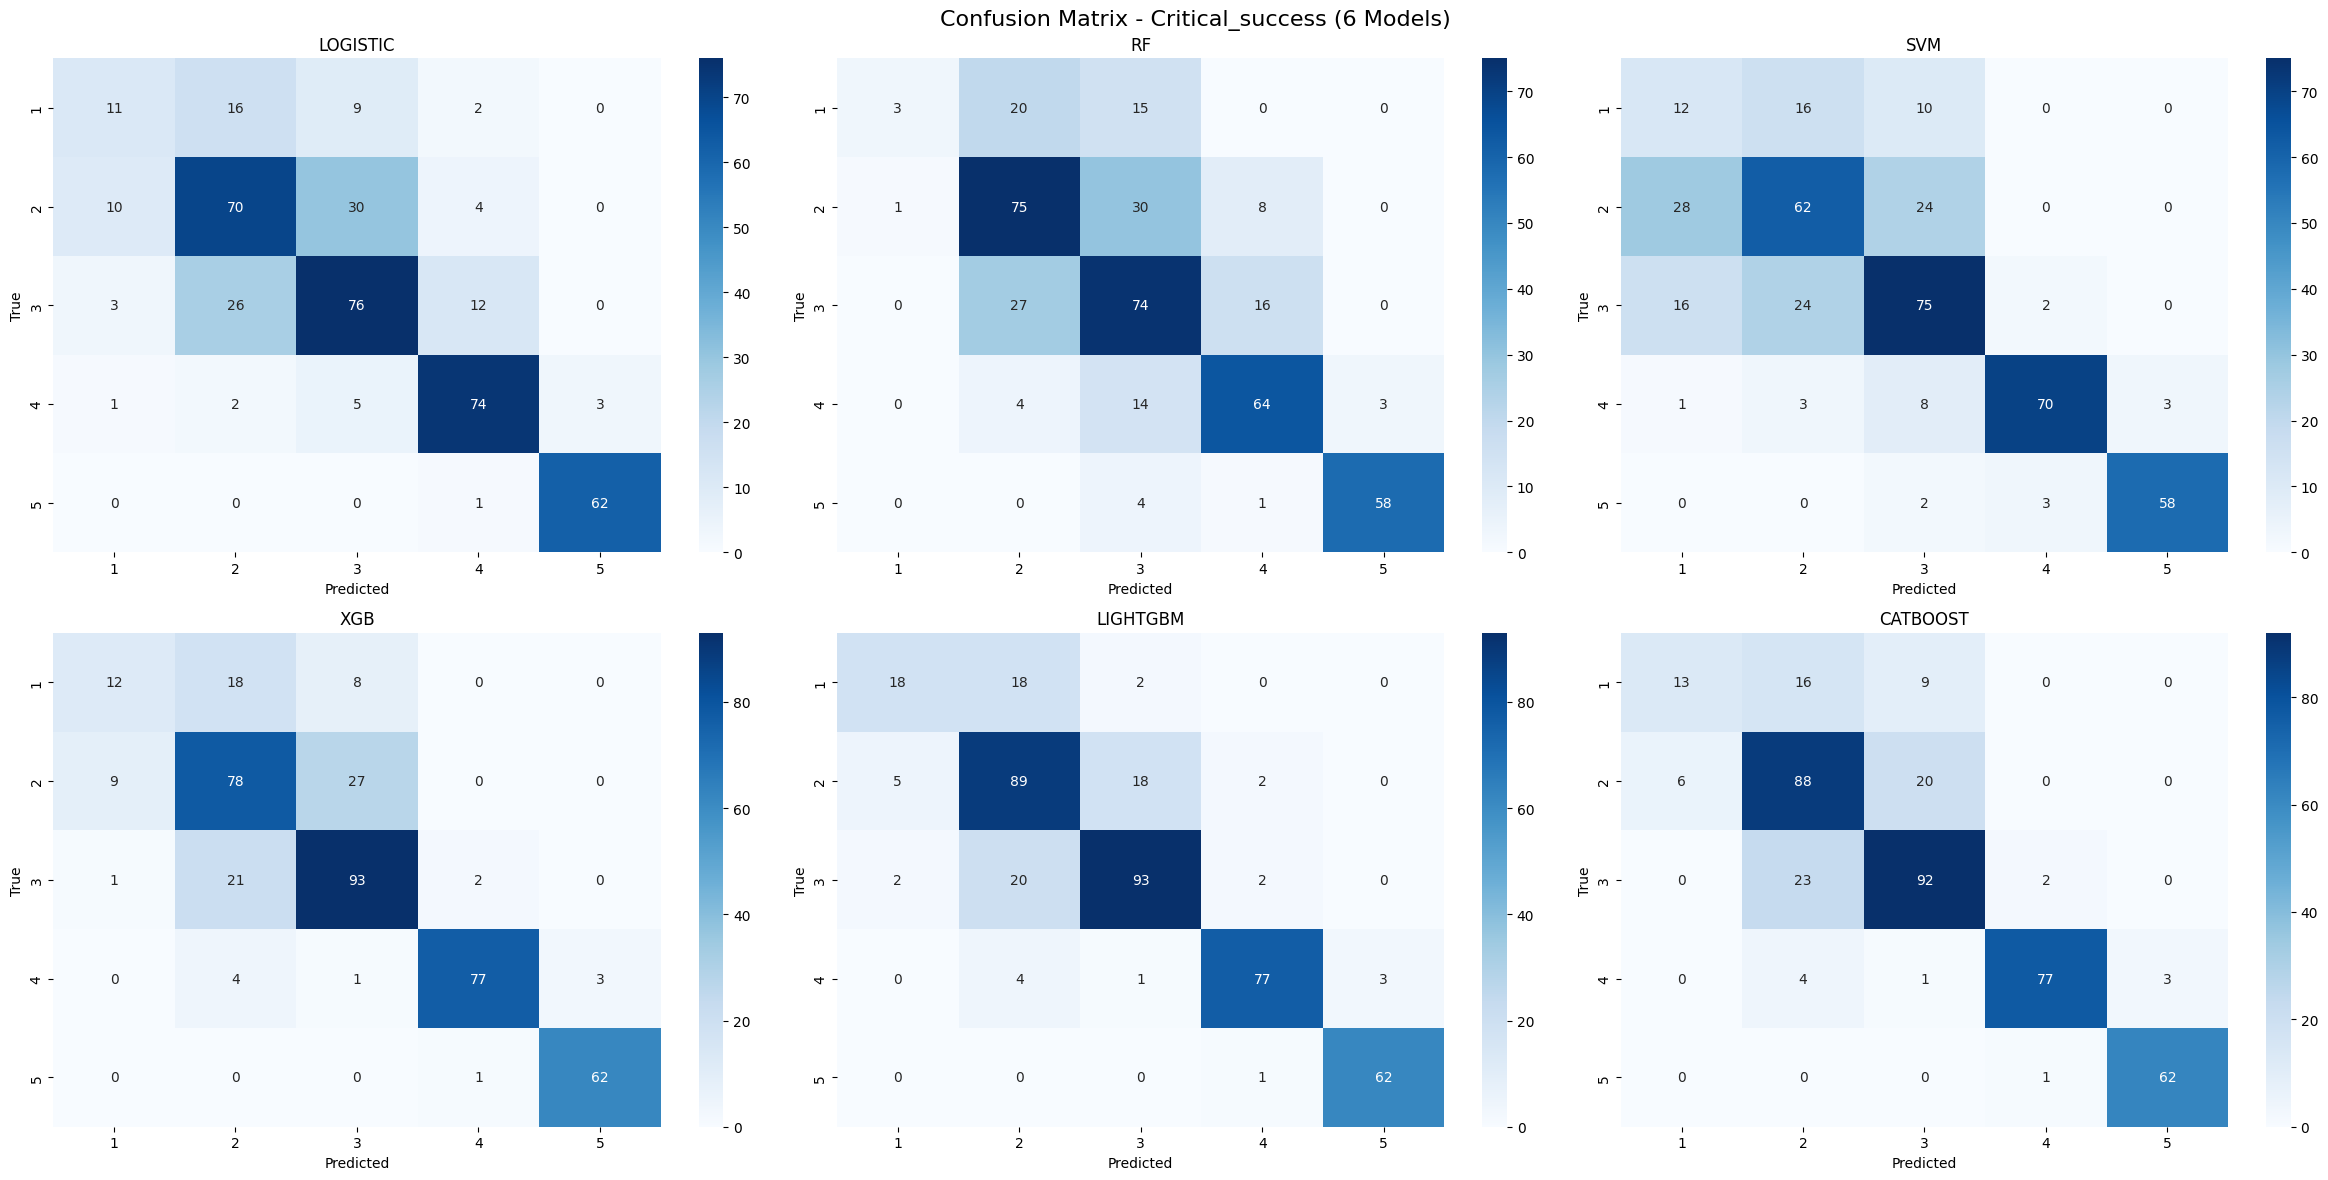


🎉 Hoàn tất đánh giá 6 model (4 traditional + LightGBM + CatBoost)!
   Plots lưu tại: /home/check/DATA/university/yr3, hk1/DS102 - ML for Statistic/Đồ án/goodread/DS102/models/LightGBM & Catboost/plots


In [34]:
fig, axes = plt.subplots(2, 3, figsize=(24, 12))
fig.suptitle('Confusion Matrix - Critical_success (6 Models)', fontsize=16)

plot_idx = 0
for name, model in models.items():
    row, col = plot_idx // 3, plot_idx % 3
    if name in ["lightgbm", "catboost"]:
        y_pred_crit = model['Critical_success'].predict(X_test).flatten() + 1
    elif name == "xgb":
        y_pred_crit = model.predict(X_test)[:, 2] + 1
    else:
        y_pred_crit = model.predict(X_test)[:, 2]
    
    cm = confusion_matrix(y_test['Critical_success'], y_pred_crit)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[row, col],
                xticklabels=range(1,6), yticklabels=range(1,6))
    axes[row, col].set_title(f'{name.upper()}')
    axes[row, col].set_xlabel('Predicted')
    axes[row, col].set_ylabel('True')
    plot_idx += 1

plt.tight_layout()
plt.savefig(os.path.join(PLOTS_FOLDER, 'confusion_matrix_critical_advanced.png'), dpi=300, bbox_inches='tight')
plt.show()

print("\n🎉 Hoàn tất đánh giá 6 model (4 traditional + LightGBM + CatBoost)!")
print(f"   Plots lưu tại: {PLOTS_FOLDER}")